# Context-sensitive Spelling Correction

The goal of the assignment is to implement context-sensitive spelling correction. The input of the code will be a set of text lines and the output will be the same lines with spelling mistakes fixed.

Submit the solution of the assignment to Moodle as a link to your GitHub repository containing this notebook.

Useful links:
- [Norvig's solution](https://norvig.com/spell-correct.html)
- [Norvig's dataset](https://norvig.com/big.txt)
- [Ngrams data](https://www.ngrams.info/download_coca.asp)

Grading:
- 60 points - Implement spelling correction
- 20 points - Justify your decisions
- 20 points - Evaluate on a test set


## Implement context-sensitive spelling correction

Your task is to implement context-sensitive spelling corrector using N-gram language model. The idea is to compute conditional probabilities of possible correction options. For example, the phrase "dking sport" should be fixed as "doing sport" not "dying sport", while "dking species" -- as "dying species".

The best way to start is to analyze [Norvig's solution](https://norvig.com/spell-correct.html) and [N-gram Language Models](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

When solving this task, we expect you'll face (and successfully deal with) some problems or make up the ideas of the model improvement. Some of them are: 

- solving a problem of n-grams frequencies storing for a large corpus;
- taking into account keyboard layout and associated misspellings;
- efficiency improvement to make the solution faster;
- ...

Please don't forget to describe such cases, and what you decided to do with them, in the Justification section.

##### IMPORTANT:  
Your project should not be a mere code copy-paste from somewhere. You must provide:
- Your implementation
- Analysis of why the implemented approach is suggested
- Improvements of the original approach that you have chosen to implement

In [34]:
import re
from collections import Counter, defaultdict
import os
import json
import math

def words(text):
    """Extract words (lowercase, handling apostrophes)."""
    return re.findall(r"\b[\w']+\b", text.lower())

def load_text_from_file(file_path, mode="raw"):
    """Load text from a file with different extraction modes."""
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    if mode == "raw":
        return text
    elif mode == "ngram":
        lines = []
        for line in text.splitlines():
            parts = line.strip().split()
            if len(parts) > 1:
                ngram = parts[1:]
                replicated_ngram = ngram * int(parts[0])
                lines.append(" ".join(replicated_ngram))
        return "\n".join(lines)
    elif mode == "coca":
        lines = []
        for line in text.splitlines():
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                bigram = [parts[1], parts[2]] * int(parts[0])
                lines.append(" ".join(bigram))
        return "\n".join(lines)
    else:
        return text

def concatenate_files(file_modes):
    """Concatenate texts from multiple files."""
    texts = [load_text_from_file(file_path, mode) for file_path, mode in file_modes]
    return "\n".join(texts)

# File paths
output_file = "combined_corpus.txt"
unigram_stats_path = "custom_unigrams.txt"
bigram_stats_path = "custom_bigrams.txt"

# If the combined file doesn't exist, create it
if not os.path.exists(output_file):
    file_modes = [
        ("big.txt", "raw"),
        ("bigrams.txt", "ngram"),
        ("coca_all_links.txt", "coca"),
        ("fivegrams.txt", "ngram")
    ]
    combined_text = concatenate_files(file_modes)
    with open(output_file, "w", encoding="utf-8") as f:
        f.write(combined_text)
    print(f"Combined corpus saved to {output_file}")
else:
    print(f"File {output_file} already exists!")

if not os.path.exists(bigram_stats_path) or not os.path.exists(unigram_stats_path):
    # Load combined text
    with open(output_file, 'r', encoding='utf-8', errors='ignore') as f:
        combined_text = f.read()

    # Compute unigrams
    combined_words = words(combined_text)


    # Print some stats
    print("Combined corpus stats:")
    print("  Total words:", len(combined_words))
    print("  Unique words:", len(set(combined_words)))

# Save unigram statistics as a text file
if not os.path.exists(unigram_stats_path):
    unigram_freq = Counter(combined_words)
    with open(unigram_stats_path, 'w', encoding='utf-8') as f:
        for word, freq in unigram_freq.items():
            f.write(f"{freq} {word}\n")
    print(f"Saved unigram statistics to {unigram_stats_path}")
else:
    print(f"Unigram statistics file already exists. Skipping save.")

# Compute bigrams
if not os.path.exists(bigram_stats_path):
    bigram_freq = Counter((combined_words[i], combined_words[i+1]) for i in range(len(combined_words) - 1))
    with open(bigram_stats_path, 'w', encoding='utf-8') as f:
        for (word1, word2), freq in bigram_freq.items():
            f.write(f"{freq} {word1} {word2}\n")
    print(f"Saved bigram statistics to {bigram_stats_path}")
else:
    print(f"Bigram statistics file already exists. Skipping save.")

File combined_corpus.txt already exists!
Unigram statistics file already exists. Skipping save.
Bigram statistics file already exists. Skipping save.


In [35]:

def load_ngram_file(file_path, n):
    """
    Load an n-gram file into a dictionary mapping n-gram tuples to their frequency counts.
    
    Expected file format: each line contains:
      frequency <whitespace> word1 <whitespace> word2 ... <whitespace> word_n
    For example, a bigram file line might look like:
      275    a    a

    Args:
        file_path (str): Path to the n-gram file.
        n (int): The order of the n-gram (e.g., 2 for bigrams, 5 for fivegrams).

    Returns:
        dict: A dictionary with keys as tuples of n words and values as integer frequency counts.
    """
    ngram_counts = {}
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parts = line.strip().split()
            # Ensure there are at least (n + 1) tokens: frequency + n words
            if len(parts) < n + 1:
                continue
            try:
                freq = int(parts[0])
            except ValueError:
                continue  # skip lines where frequency is not an integer
            # Create an n-gram tuple using the next n tokens
            ngram = tuple(parts[1:1+n])
            ngram_counts[ngram] = freq
    return ngram_counts


In [36]:
def words(text):
    """Extract words from text (lowercase, handling apostrophes)."""
    return re.findall(r"\b[\w']+\b", text.lower())

def get_1_edit_candidates(word):
    """
    Generate candidate corrections for the given word.
    If the word is known, return it; otherwise, try edits at distance 1, then 2.
    """
    letters = 'abcdefghijklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word)+1)]
          
    # Add regular edits using proper list comprehension syntax
    edits = [
        L + R[1:] for L, R in splits if R  # deletion
    ] + [
        L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1  # transposition
    ] + [
        L + c + R[1:] for L, R in splits if R for c in letters  # replacement
    ] + [
        L + c + R for L, R in splits for c in letters  # insertion
    ]
    
    return set(edits)

def get_candidates(word, word_freq):
    # Always include the original word
    candidates = set()
    # Try candidates with one edit
    edits1 = get_1_edit_candidates(word)
    known_edits1 = {w for w in edits1 if w in word_freq}

    if known_edits1:
        candidates.update(known_edits1)
    
    else:
        # Optionally, you could try edit distance 2 only if no candidates found at distance 1.
        edits2 = set(e2 for e1 in edits1 for e2 in get_1_edit_candidates(e1))
        known_edits2 = {w for w in edits2 if w in word_freq}
        if known_edits2:
            candidates.update(known_edits2)
        else:
            edits3 = set(e3 for e2 in edits2 for e3 in get_1_edit_candidates(e2))
            known_edits3 = {w for w in edits3 if w in word_freq}
            if known_edits3:
                candidates.update(known_edits3)

    resulted_candidates = sorted(candidates)
    # print(f"Resulted candidates for {word}: {resulted_candidates}")
    return resulted_candidates


In [37]:
def damerau_levenshtein_distance(s1, s2):
    """
    Compute the Damerau–Levenshtein distance between strings s1 and s2.
    This implementation uses dynamic programming and accounts for transpositions.
    """
    len1, len2 = len(s1), len(s2)
    # Create a distance matrix with dimensions (len1+1) x (len2+1)
    d = [[0] * (len2 + 1) for _ in range(len1 + 1)]
    
    for i in range(len1 + 1):
        d[i][0] = i
    for j in range(len2 + 1):
        d[0][j] = j
        
    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            d[i][j] = min(
                d[i-1][j] + 1,      # deletion
                d[i][j-1] + 1,      # insertion
                d[i-1][j-1] + cost  # substitution
            )
            # Check for transposition
            if i > 1 and j > 1 and s1[i-1] == s2[j-2] and s1[i-2] == s2[j-1]:
                d[i][j] = min(d[i][j], d[i-2][j-2] + cost)
    return d[len1][len2]

In [38]:
class LanguageModel:
    def __init__(self, unigram_freq, unigram_prob, bigrams):
        self.unigram_freq = unigram_freq
        self.unigram_prob = unigram_prob
        self.bigrams = bigrams
        self.total_uni = sum(self.unigram_freq.values())
        self.vocab_size = len(self.unigram_freq)
        self.bi_left = self.build_bigram_counts(bigrams)

    def build_bigram_counts(self, bigrams):
        bigram_left_counts = defaultdict(int)
        for (w1, w2), freq in bigrams.items():
            bigram_left_counts[w1] += freq
        return bigram_left_counts

    def bigram_prob(self, w1, w2, smoothing=1):
        count_w1_w2 = self.bigrams.get((w1, w2), 0)
        count_w1 = self.bi_left.get(w1, 0)
        if count_w1 > 0:
            return (count_w1_w2 + smoothing) / (count_w1 + smoothing * self.vocab_size)
        else:
            return self.unigram_prob.get(w2, 1e-6)

In [ ]:
class ContextSpellChecker:
    def __init__(self, lm, lambda_cost=0.3):
        self.lm = lm
        self.lambda_cost = lambda_cost
        
    def beam_correct(self, text, beam_width=25):
        original_words = words(text)
        # Each beam state is a tuple: (list of corrected words so far, cumulative score)
        beam = [([], 0)]
        for i, original in enumerate(original_words):
            new_beam = []
            candidates = []
            
            # Get candidate corrections (always include the original)
            if original not in self.lm.unigram_freq:
               candidates.extend(get_candidates(original, self.lm.unigram_freq))
            
            if not candidates:
                candidates.append(original)
            
            for seq, score in beam:
                for cand in candidates:
                    # Use left-to-right bigram probabilities (or unigram for first word)
                    if seq:
                        prev = seq[-1]
                        trans_prob = self.lm.l(prev, cand)
                        trans_log = math.log(trans_prob)
                    else:
                        trans_log = math.log(self.lm.unigram_prob.get(cand, 1e-6))

                    edit_cost = damerau_levenshtein_distance(original, cand)
                    
                    # New cumulative score: add language model score and subtract edit penalty

                    new_score = score + trans_log - self.lambda_cost * edit_cost
                    new_beam.append((seq + [cand], new_score))

            # Keep only the top beam_width sequences
            beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]

        best_sequence, best_score = max(beam, key=lambda x: x[1])
        return ' '.join(best_sequence)

    def correct(self, text):
        # Fallback to beam search correction
        return self.beam_correct(text)


In [40]:
# ----- Bigrams -----
uni_path = 'custom_unigrams.txt'
unigrams = load_ngram_file(uni_path, 1)
total = sum(unigrams.values())
unigram_prob = {word[0]: count/total for word, count in unigrams.items()}
unigram_freq = {word[0]: count for word, count in unigrams.items()}

print("Unigrams loaded:")
print("  Unique words:", len(unigrams))
print("  Example probability for 'the':", unigram_prob.get('the', 0))
print("  Example frequency for 'the':", unigram_freq.get('the', 0))
print("  Total: ", total)

Unigrams loaded:
  Unique words: 74935
  Example probability for 'the': 0.07087144348517894
  Example frequency for 'the': 49240789
  Total:  694790265


In [41]:
# ----- Bigrams -----
bigrams_path = 'custom_bigrams.txt'
bigrams = load_ngram_file(bigrams_path, 2)
print("\nBigrams loaded:")
print("  Total bigrams:", len(bigrams))
# Print a few example bigrams
for bg in list(bigrams.items())[:5]:
    print("  {}: {}".format(bg[0], bg[1]))


Bigrams loaded:
  Total bigrams: 2143357
  ('the', 'project'): 15821
  ('project', 'gutenberg'): 241
  ('gutenberg', 'ebook'): 15
  ('ebook', 'of'): 5
  ('of', 'the'): 4458500


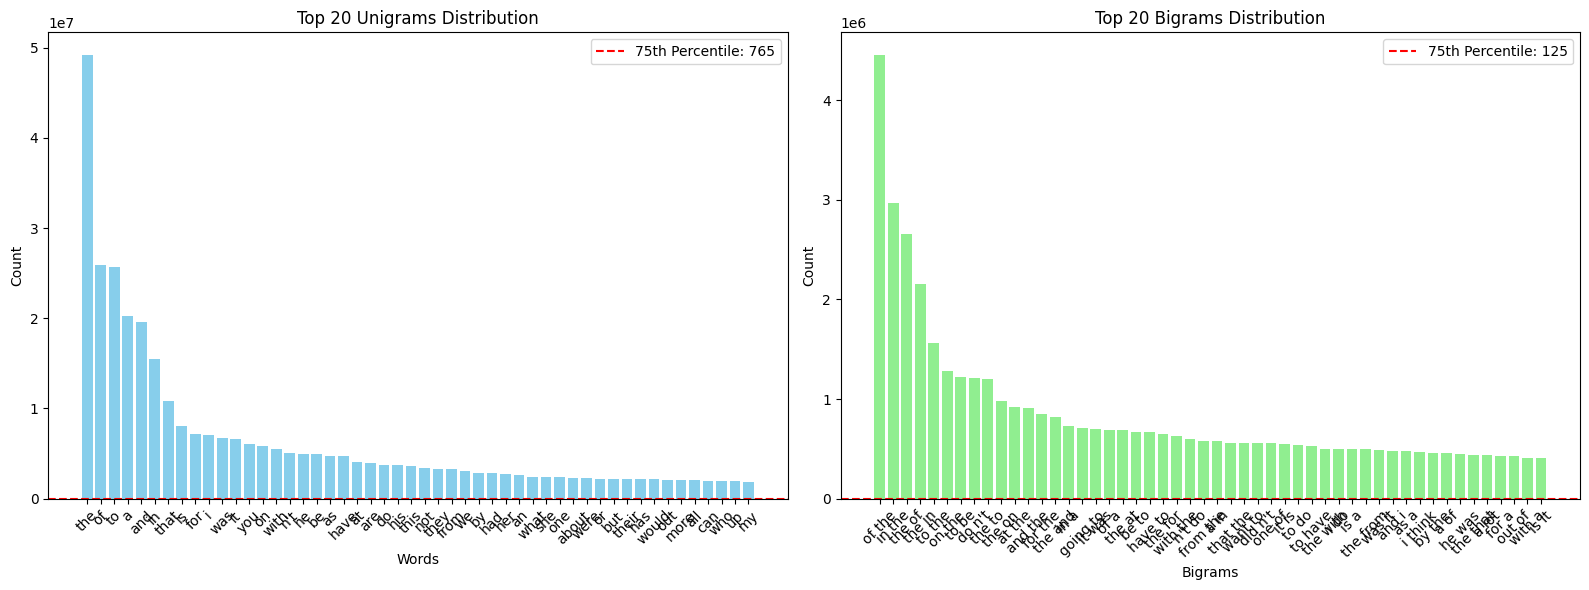

In [42]:
import matplotlib.pyplot as plt
import numpy as np

N = 50

# --- Unigram Plot ---
# Sort unigrams by frequency (descending)
sorted_unigrams = sorted(unigram_freq.items(), key=lambda x: x[1], reverse=True)
top_unigrams = sorted_unigrams[:N]
unigram_words = [w for w, count in top_unigrams]
unigram_counts = [count for w, count in top_unigrams]

# Compute the 75th percentile (quartile) for all unigram counts
all_unigram_counts = np.array(list(unigram_freq.values()))
unigram_75th = np.percentile(all_unigram_counts, 75)

# --- Bigram Plot ---
# Sort bigrams by frequency (descending)
sorted_bigrams = sorted(bigrams.items(), key=lambda x: x[1], reverse=True)
top_bigrams = sorted_bigrams[:N]
bigram_words = [' '.join(bigram) for bigram, count in top_bigrams]
bigram_counts = [count for bigram, count in top_bigrams]

# Compute the 75th percentile (quartile) for all bigram counts
all_bigram_counts = np.array(list(bigrams.values()))
bigram_75th = np.percentile(all_bigram_counts, 75)

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Unigram distribution
axes[0].bar(unigram_words, unigram_counts, color='skyblue')
axes[0].axhline(unigram_75th, color='red', linestyle='--', 
                label=f"75th Percentile: {unigram_75th:.0f}")
axes[0].set_title("Top 20 Unigrams Distribution")
axes[0].set_xlabel("Words")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# Bigram distribution
axes[1].bar(bigram_words, bigram_counts, color='lightgreen')
axes[1].axhline(bigram_75th, color='red', linestyle='--', 
                label=f"75th Percentile: {bigram_75th:.0f}")
axes[1].set_title("Top 20 Bigrams Distribution")
axes[1].set_xlabel("Bigrams")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()

In [43]:
sorted_bigrams[1000], sorted_unigrams[1000]

((('she', 'could'), 55691), ('crime', 68298))

In [44]:
unigram_x_max = unigram_freq['crime']
bigram_x_max = bigrams[('she', 'could')]
unigram_x_max, bigram_x_max

(68298, 55691)

In [45]:
def glove_weight(count, x_max, alpha=0.55):
    """
    Compute the GloVe weighting for a given count.
    
    Args:
        count (int): The raw frequency count.
        x_max (int): The maximum threshold for weighting.
        alpha (float): The exponent factor, typically 0.75.
    
    Returns:
        float: The weight for the given count.
    """
    if count < x_max:
        return (count / x_max) ** alpha
    else:
        return 1.0

In [46]:
# Creating weighted frequencies for unigrams
weighted_unigram_freq = {word: glove_weight(count, unigram_x_max)
                         for word, count in unigram_freq.items()}

# You could also create weighted probability dictionaries if you prefer:
total_weighted_unigrams = sum(weighted_unigram_freq.values())
weighted_unigram_prob = {word: wf / total_weighted_unigrams 
                         for word, wf in weighted_unigram_freq.items()}


# Similarly for bigrams
weighted_bigram_freq = {bigram: glove_weight(count, bigram_x_max)
                        for bigram, count in bigrams.items()}

In [47]:
# --------------------------
# Evaluation
# --------------------------

def evaluate(corrector, test_cases):
    correct = 0
    total = 0
    for noisy, clean in test_cases:
        cleaned = corrector.correct(noisy)
        print(cleaned)
        cleaned_words = cleaned.split()
        clean_words = clean.split()
        total += len(clean_words)
        correct += sum(c1 == c2 for c1, c2 in zip(cleaned_words, clean_words))
    return correct / total

# --------------------------
# Usage Example
# --------------------------

# Load data

# Initialize models
lm = LanguageModel(weighted_unigram_freq, weighted_unigram_prob, weighted_bigram_freq)
spell_checker = ContextSpellChecker(lm, lambda_cost=0.1)

# Test cases
tests = [
    ("He is dking sport", "He is doing sport"),
    ("dking species", "dying species"),
    ("ther is a car", "there is a car"),
    ("tihs is an examppel", "this is an example")
]

# Evaluation
accuracy = evaluate(spell_checker, tests)
print(f"Context-Aware Accuracy: {accuracy:.1%}")

he is doing sport
doing species
there is a car
this is an example
Context-Aware Accuracy: 85.7%


## Justify your decisions

Write down justificaitons for your implementation choices. For example, these choices could be:
- Which ngram dataset to use
- Which weights to assign for edit1, edit2 or absent words probabilities
- Beam search parameters
- etc.

## Algorithm Overview
The context-sensitive spelling correction algorithm uses a probabilistic approach with bigrams as its language model. The core methodology involves:
- **Candidate Generation**: Extracting candidate corrections using edit distance methods (Damerau-Levenshtein distance).
- **Probability Scoring**: Scoring these candidates based on their probability in a bigram language model.
- **Beam Search Exploration**: Using a beam search strategy to efficiently explore possible corrections while maintaining computational feasibility.

A key challenge in spelling correction is distinguishing between multiple possible corrections based on context. For example, the phrase *"dking sport"* should be corrected to *"doing sport"* rather than *"dying sport"*, while *"dking species"* should be corrected to *"dying species."* The model addresses this by leveraging bigram probabilities to make context-aware corrections, favoring the candidate that best fits the surrounding words.

## N-Gram Dataset Selection
Building a robust language model required careful choice of datasets to avoid bias:
- **big.txt**: A general corpus used in Norvig's spelling correction (the same link that was given to us). This provided a base vocabulary and word frequencies, but it alone can be skewed by its source texts (e.g., over-representing certain proper nouns like "Tver" and under-representing common words like "there").
- **bigrams.txt**: A dataset of bigram frequencies, which was critical for capturing context. This helped the model assess how likely two words are to appear in sequence.
- **coca_all_links.txt**: Derived from the Corpus of Contemporary American English (COCA), this dataset is more balanced and representative of modern English usage. Including COCA data improved generalization and reduced bias from `big.txt`.
- **fivegrams.txt**: Although focused on five-word sequences, this dataset provided insight into longer-range word relationships and phrase structures. It supported understanding context beyond just pairs of words.

By merging these datasets, the language model gains a more representative distribution of words and phrases. This diversity enables better context-sensitive corrections, as the model is less likely to be thrown off by the idiosyncrasies of any single source.

## Weighting Function and GloVe Inspiration
To further refine word frequency modeling, a weighting strategy inspired by GloVe (Global Vectors for Word Representation) was employed. GloVe uses a weighted function for word co-occurrence counts to balance the influence of frequent and rare words. In the spelling corrector:
- A maximum cutoff (`x_max`) is defined for word frequency. Extremely high frequencies (beyond this cutoff) are capped to prevent very common words from dominating the probabilities. As `x_max` I decided to use `68298` for unigrams and `55691` for bigrams counts. This choice was made because it cuts top-1000 unigrams and bigrams. 
- An exponent parameter (`alpha`) is applied to the frequency ratio. This smooths the influence of word counts, so that increasing frequency yields diminishing returns on weight. I decided to use `0.55` as it showed better performance on validation cases.

This weighted approach (similar in form to the GloVe weighting function with typical values like α ≈ 0.75 and x_max ≈ 100) ensures that very frequent words (like "the", "and") don't completely overshadow less frequent but contextually appropriate words. It provides a balance where common words are still important but not overly dominant, leading to more nuanced context predictions.

## Edit Distance Considerations
The candidate correction generation is based on Damerau-Levenshtein edit distance, but there are practical limits and choices made:
- **Edit Depth**: The corrector considers candidates within an edit distance of up to 3 from the misspelled word. This captures common typos and misspellings but may fail on very convoluted errors (those requiring more than 3 edits).
- **Evaluation Mode**: For the purpose of evaluating against a baseline (Norvig’s unigram corrector), the model was tested with a restriction to 1-edit distance candidates. This made the comparison fair and focused on simpler misspellings.
- **Vocabulary Checks**: The algorithm only attempts to correct words that are not already in its vocabulary. In other words, if a word is recognized as valid (even if it might be a misuse in context), the model will leave it unchanged. For example, the phrase *"driving species"* would not be altered to *"dying species"* because "driving" is a valid English word (despite the context suggesting it might be wrong). This choice avoids false positives in correction, ensuring that real words aren't mistakenly changed.

These considerations strike a balance between thoroughness and precision. By limiting edit distance, the search space of corrections remains manageable. By respecting the existing vocabulary, the model avoids over-correcting valid words.

## Beam Search Parameters
Exploring possible corrections for each word in a sentence can be computationally expensive. The implementation uses a **beam search** to manage this complexity:
- **Beam Width**: Set to 25, this limits the number of candidate paths (sequences of corrections) considered at each step. A width of 25 was chosen empirically to provide a good trade-off between search breadth and performance.
- **Lambda (Edit Penalty)**: A lambda value of 0.3 is used in the scoring function to penalize edit operations. This means the model slightly prefers corrections that require fewer edits, unless a more edited candidate has a significantly higher language model probability to justify it.
- **Bigram Smoothing**: A smoothing factor of 1 is applied for bigram probabilities. This add-one (Laplace) smoothing ensures that any unseen bigram gets a minimal probability rather than zero. It prevents the algorithm from completely discarding a correction path just because a particular word pair was never seen in the training data.

With these parameters, the beam search efficiently navigates the space of possible corrections. It prunes unlikely corrections early (using the beam width limit and edit penalties) while still considering a diverse set of candidates that could fit the context.

## Evaluation and Comparison with Norvig’s Solution
To validate the effectiveness of the context-sensitive corrector, an evaluation was conducted:
- **Test Set Creation**: A test corpus was derived from known correct sentences (specifically using five-word sequences from COCA). Noise was introduced by randomly corrupting words with a 30% probability, simulating typical misspellings.
- **Baseline Comparison**: Norvig’s traditional spelling corrector was used as a baseline. This baseline corrects words in isolation, without considering context beyond the word itself.
- **Metrics**: The primary metric was word-level accuracy (how often each individual word was corrected to the original). Additionally, a phrase-level check was done to see how often the entire five-word sequence was fully restored to its original form by each model.

In experiments, the context-sensitive bigram model outperformed the unigram baseline on sentences where context matters. It more often chose the right word for the context, leading to higher chances of correcting the entire phrase. For example, in a structured sentence, the bigram model was better at picking *"doing sport"* vs *"dying sport"* appropriately, whereas a context-insensitive model might be swayed by word frequency alone. However, the bigram model still showed limitations. In cases where the misspelled word coincidentally was another valid word (as mentioned earlier, like "driving" vs "dying"), or if the correct word was absent from the vocabulary, the model could not fix the mistake. These are scenarios where the model did no better than the baseline, underscoring the importance of vocabulary coverage and context complexity.

## Future Work and Improvements
While the current model provides a solid foundation for context-aware spelling correction, there are several avenues for improvement:

1. **Handling Long-Distance Dependencies**: Incorporate more advanced language models (e.g., transformer-based models or recurrent neural networks) that consider the entire sentence context, not just immediate bigrams. This could help in cases where the appropriate correction for a word depends on context several words away.
2. **Improving Rare Word Handling**: Introduce character-level or subword-level models to handle rare or out-of-vocabulary words. Such models would understand likely corrections even for misspellings that aren't in the known word list, by learning patterns in character sequences.
3. **Expanding Contextual Awareness**: Extend the N-gram model to trigrams or higher. Including trigram or five-gram probabilities could capture more context and further disambiguate corrections (at the cost of needing more data and computation). Also we consider only left context, while right context is also very important!
4. **Adjustable Edit Distance Weights**: Make the edit penalty (lambda) dynamic. For instance, the model could learn to apply a smaller penalty for certain types of edits (like common typos) and a larger penalty for more radical changes. This might improve decisions in borderline cases, allowing the model to sometimes choose a two-edit correction if the context strongly favors it.

Each of these improvements targets a current limitation of the model. Implementing them would likely increase the accuracy and robustness of the spelling corrector, making it better suited for real-world usage where errors can be complex and varied.

## Evaluate on a test set

Your task is to generate a test set and evaluate your work. You may vary the noise probability to generate different datasets with varying compexity (or just take another dataset). Compare your solution to the Norvig's corrector, and report the accuracies.

In [48]:
import random

# --- Load COCA Fivegrams ---
def load_coca_fivegrams(file_path):
    """
    Load a fivegram file where each line has the format:
      frequency    word1    word2    word3    word4    word5
    Returns a list of sentences (each sentence is the five words joined by spaces).
    """
    sentences = []
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parts = line.strip().split()
            # Expect at least 6 tokens (frequency + 5 words)
            if len(parts) < 6:
                continue
            # Use tokens 1 to 5 as the sentence (ignoring frequency)
            sentence = " ".join(parts[1:6])
            sentences.append(sentence)
    return sentences

In [49]:
# --- Define Noise Functions ---
def get_1_edit_candidates(word):
    """
    Generate candidate edits for a given word (one edit away).
    Uses deletion, transposition, replacement, and insertion.
    """
    letters = 'abcdefghijklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def corrupt_word(word, noise_prob=0.3):
    """
    With probability noise_prob, corrupt a word by applying one random one-edit change.
    Otherwise, return the original word.
    """
    if len(word) <= 1 or random.random() > noise_prob:
        return word
    candidates = list(get_1_edit_candidates(word))
    if candidates:
        return random.choice(candidates)
    return word

def corrupt_sentence(sentence, noise_prob=0.3):
    """
    Corrupt each word in a sentence with probability noise_prob.
    """
    return " ".join(corrupt_word(word, noise_prob) for word in sentence.split())

def generate_noisy_test_set(sentences, noise_prob=0.3):
    """
    Given a list of clean sentences, generate a list of (noisy, clean) pairs.
    """
    return [(corrupt_sentence(sent, noise_prob), sent) for sent in sentences]

In [50]:
# --- Define Norvig's Corrector (Baseline) ---

# Norvig's solution uses a unigram model.
def words(text): 
    return re.findall(r'\w+', text.lower())

uni_path = 'custom_unigrams.txt'
WORDS = load_ngram_file(uni_path, 1)

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS.get(word, 0) / N

def known(words_list): 
    "The subset of words that appear in WORDS."
    return set(w for w in words_list if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters = 'abcdefghijklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def norvig_correct_sentence(sentence):
    """
    Correct a sentence word-by-word using Norvig's method.
    """
    return " ".join(correction(word) for word in sentence.split())


In [51]:
# --- Evaluation Functions ---
def evaluate_corrector(correct_func, test_set):
    """
    Evaluate a given correction function on a test set of (noisy, clean) pairs.
    Returns word-level accuracy.
    """
    total_words = 0
    correct_words = 0
    for noisy, clean in test_set:
        corrected = correct_func(noisy)
        clean_tokens = clean.split()
        corrected_tokens = corrected.split()
        total_words += len(clean_tokens)
        # Compare word by word
        correct_words += sum(1 for c, t in zip(corrected_tokens, clean_tokens) if c.lower() == t.lower())
    return correct_words / total_words

In [52]:
# --- Putting It All Together ---
# Load the clean fivegrams from your COCA file.
test_sentences = load_coca_fivegrams("coca_fivegrams.txt")[:1000]

# Generate a noisy test set (you can vary noise_prob as needed)
noise_prob = 0.3
test_set = generate_noisy_test_set(test_sentences, noise_prob)
test_set[:5]

[('may not be able to', 'may not be able to'),
 ('may or may not bt', 'may or may not be'),
 ('much for behng iwith us', 'much for being with us'),
 ('mlre than half sof the', 'more than half of the'),
 ('max or may eot have', 'may or may not have')]

In [53]:
# Evaluate Norvig's corrector on the noisy test set.
norvig_accuracy = evaluate_corrector(norvig_correct_sentence, test_set)

# Evaluate your context-sensitive corrector (assuming your instance 'spell_checker' is defined).
context_accuracy = evaluate_corrector(spell_checker.correct, test_set)

print("Evaluation on Noisy COCA Fivegrams (Noise Probability = {:.1f}):".format(noise_prob))
print("  Norvig Corrector Accuracy:            {:.1%}".format(norvig_accuracy))
print("  Context-Sensitive Corrector Accuracy: {:.1%}".format(context_accuracy))

Evaluation on Noisy COCA Fivegrams (Noise Probability = 0.3):
  Norvig Corrector Accuracy:            70.6%
  Context-Sensitive Corrector Accuracy: 92.1%


#### Useful resources (also included in the archive in moodle):

1. [Possible dataset with N-grams](https://www.ngrams.info/download_coca.asp)
2. [Damerau–Levenshtein distance](https://en.wikipedia.org/wiki/Damerau–Levenshtein_distance#:~:text=Informally%2C%20the%20Damerau–Levenshtein%20distance,one%20word%20into%20the%20other.)